In [1]:
import math 
import os
from pathlib import Path
import heapq
from collections import *
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
BASE_PATH = Path('/Users/vinay/ub/spring-22/CSE573-CVIP/BackgroundStitching/images/pano')

In [3]:
def show_batch(imgs, size=20, dpi=100):
    n = len(imgs)
    col = 4
    row = (n // col) + 1 
    fig = plt.figure(figsize=(size, size), dpi=dpi)
    grid = ImageGrid(
        fig, 111,
        nrows_ncols=(row, col), 
        axes_pad=0.4, 
     )
    
    for idx, (ax, im) in enumerate(zip(grid, imgs)):
        # Iterating over the grid returns the Axes.
        im= cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        ax.imshow(im, cmap='gray')
        ax.set_title(f'Image {idx}')
        
    plt.show()

def read_batch(path, scale_factor = 1.0):
    imgs = {}
    lis = list(os.walk(path))
    
    if lis:
        p, _, files = lis[0]
        idx = 0
        for file in files:
            if '.DS_Store' not in file:
                imgs[idx] = cv2.imread(f'{p}/{file}')
                if scale_factor != 1.0:
                    imgs[idx] = resize(imgs[idx], scale_factor)
                idx += 1

    return imgs

def show(img, dpi=100, disable_axis=True, color=True):
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    plt.figure(dpi=dpi)
    plt.imshow(img, cmap='gray')
    
    if disable_axis:
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
def shape(img):
    s = img.shape
    a = 0
    if len(s) == 3:
        h, w, a = img.shape
    else:
        h, w = img.shape
        
    return h, w, a

def img2c(img):
    size = img.shape
    return (0, 0, size[1], size[0])

In [4]:
def extract_features(image, extractor):
    keypoints, desc = extractor.detectAndCompute(image, None)
    return keypoints, desc

def extract_all_features(imgs):
    sift = cv2.SIFT_create()
    feature_desc = np.array(
        list(map(lambda x: extract_features(x, sift), imgs)),
        dtype=object,
    )[:, 1]
    
    return feature_desc

def pairwise(X, Y):
    dists = -2 * np.dot(X, Y.T) + np.sum(np.square(Y), axis=1, keepdims=True).T + np.sum(np.square(X), axis=1, keepdims=True)
    return np.sqrt(dists)

def get_matching_points(matches, kp1, kp2):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])
    return src_pts, dst_pts

def match_desc(desc1, desc2, lowes_ratio=0.8):
    pair_dist = pairwise(desc1, desc2)
    min_pairs = np.partition(pair_dist, 1)[:, :2]
    idx = (min_pairs[:, 0] / min_pairs[:, 1]) < lowes_ratio
    n_matches = len(min_pairs[idx])
    matches = []

    for q_idx, t_idx in zip(np.nonzero(idx)[0], np.argmin(pair_dist[idx], 1)):
        matches.append(
            cv2.DMatch(
                _queryIdx=q_idx,
                _trainIdx=t_idx,
                _distance=pair_dist[q_idx, t_idx],
            )
        )
        
    return matches, n_matches

def homography(match_pts, cv=True):
    src_pts, dst_pts = match_pts
    k = cv2.RANSAC if cv is True else 0
    h, mask = cv2.findHomography(src_pts, dst_pts, k)
    
    return h, mask

def translate(dx, dy):
    t = np.float32(
        [
            [1, 0, dx],
            [0, 1, dy],
            [0, 0,  1],
        ]
    )
    return t

def translate_homography(dx, dy, H):
    dx, dy = abs(dx) if dx < 0 else 0, abs(dy) if dy < 0 else 0
    transform = np.float32(
        [
            [1, 0, dx],
            [0, 1, dy],
            [0, 0,  1],
        ]
    )
    new_h = transform.dot(H)
    return new_h, (dx, dy)

def apply_homography(args, img1, img2, H, mask):
    img1 = img1.copy()
    img2 = img2.copy()
    
    h, w, _ = shape(img1)
    (matches, (kp1, kp2)) = args
    
    pts = np.float32([ [0, 0],[0, h-1],[w-1, h-1],[w-1, 0] ]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, H)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    draw_params = dict(
        matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = mask, # draw only inliers
        flags = 2,
    )
    img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)
    
    return img

def transform(coordinates, homography):
    x, y, w, h = coordinates
    src = np.float32([[x, y], [x, y + h - 1], [x + w - 1, y], [x + w - 1, y + h - 1]]).reshape(-1, 1, 2)
    
    dst = cv2.perspectiveTransform(src, homography)
    l, _, _ = dst.shape
    dst = dst.reshape((l, 2))
    
    min_x, max_x = np.min(dst[:, 0]), np.max(dst[:, 0])
    min_y, max_y = np.min(dst[:, 1]), np.max(dst[:, 1])
    
    new_x = int(np.floor(min_x))
    new_y = int(np.floor(min_y))
    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))
    
    return new_x, new_y, new_w, new_h

In [5]:
def addBorder(img, rect):
    top, bottom, left, right = int(0), int(0), int(0), int(0)
    x, y, w, h = rect
    tl = (x, y)    
    br = (x + w, y + h)
    if tl[1] < 0:
        top = -tl[1]
    if br[1] > img.shape[0]:
        bottom = br[1] - img.shape[0]
    if tl[0] < 0:
        left = -tl[0]
    if br[0] > img.shape[1]:
        right = br[0] - img.shape[1]
    img = cv2.copyMakeBorder(img, top, bottom, left, right,
                            cv2.BORDER_CONSTANT, value=[0, 0, 0])
    orig = (left, top)
    return img, orig

def mean_blend(img1, img2):
    assert(img1.shape == img2.shape)
    locs1 = np.where(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) != 0)
    blended1 = np.copy(img2)
    blended1[locs1[0], locs1[1]] = img1[locs1[0], locs1[1]]
    locs2 = np.where(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) != 0)
    blended2 = np.copy(img1)
    blended2[locs2[0], locs2[1]] = img2[locs2[0], locs2[1]]
    blended = cv2.addWeighted(blended1, 0.5, blended2, 0.5, 0)
    return blended

In [6]:
def warp(img_c, H):
    _, _, a = shape(img_c)
    dx, dy, _, _ = transform(img2c(img_c), H)
    new_H, (tx, ty) = translate_homography(dx, dy, H)
    x, y, w, h = transform(img2c(img_c), new_H)
    warped = cv2.warpPerspective(img_c, new_H, (x+w, y+h))
    # print(f'xpos:{dx}, ypos:{dy}')
    return warped, (tx, ty)

def merge(img1_c, img2_c, H):
    result, pos = warp(img1_c, H)
    xpos, ypos = pos
    # print(f'xpos:{xpos}, ypos:{ypos}')
    rect = (xpos, ypos, img2_c.shape[1], img2_c.shape[0])
    result, _ = addBorder(result, rect)
    idx = np.s_[ypos : ypos + img2_c.shape[0], xpos : xpos + img2_c.shape[1]]
    result[idx] = mean_blend(result[idx], img2_c)
    x, y, w, h = cv2.boundingRect(cv2.cvtColor(result, cv2.COLOR_RGB2GRAY))
    result = result[y : y + h, x : x + w]
    
    return result, (xpos-x, ypos-y)

def remove_border(img):
    x, y, w, h = cv2.boundingRect(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    img = img[y : y + h, x : x + w]
    return img

In [7]:
def get_H(img1_c, img2_c, cv=True):
    sift = cv2.SIFT_create()
    img1 = cv2.cvtColor(img1_c, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_c, cv2.COLOR_BGR2GRAY)
    
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    
    kp1, desc1 = extract_features(img1, sift)
    kp2, desc2 = extract_features(img2, sift)
    
    matches, score = match_desc(desc1, desc2, lowes_ratio=0.8)
    src_pts, dst_pts = get_matching_points(matches, kp1, kp2)
    
    if cv is False:
        K = math.sqrt((h1 + h2)**2 + (w1 + w2)**2)
        src_pts, dst_pts, mask = ransac((src_pts, dst_pts), thresh=r_thresh, factor=K)
        
    H, _ = homography((src_pts, dst_pts), cv=cv)
    
    return H

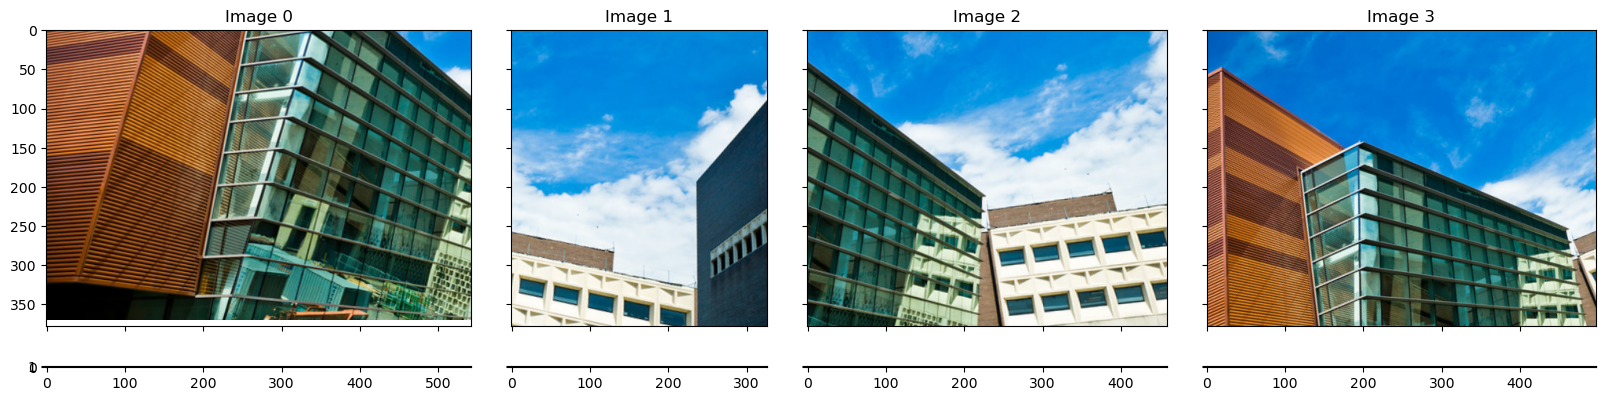

In [8]:
imgs1 = read_batch(BASE_PATH/'1')
fd1 = extract_all_features(imgs1.values())
show_batch(imgs1.values())

(304, 40)


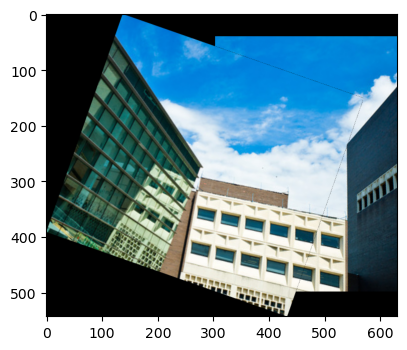

In [9]:
H21 = get_H(imgs1[2], imgs1[1])
i21, p21 = merge(imgs1[2], imgs1[1], H21)
print(p21)
show(i21, dpi=100, disable_axis=False)

(0, 82)


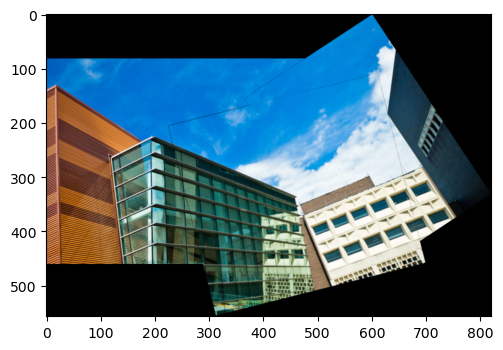

In [10]:
H21_3 = get_H(i21, imgs1[3])
i21_3, p21_3 = merge(i21, imgs1[3], H21_3)
print(p21_3)
show(i21_3, dpi=100, disable_axis=False)

(0, 125)


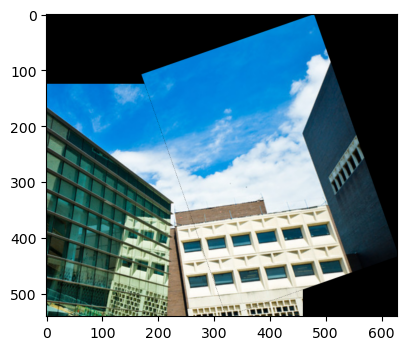

In [11]:
H12 = get_H(imgs1[1], imgs1[2])
i12, p12 = merge(imgs1[1], imgs1[2], H12)
print(p12)
show(i12, dpi=100, disable_axis=False)

(0, 0)


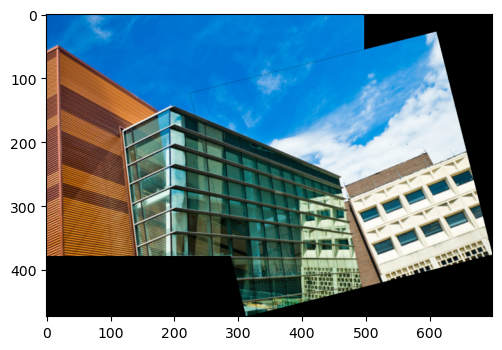

In [12]:
H23 = get_H(imgs1[2], imgs1[3])
i23, p23 = merge(imgs1[2], imgs1[3], H23)
print(p23)
show(i23, dpi=100, disable_axis=False)

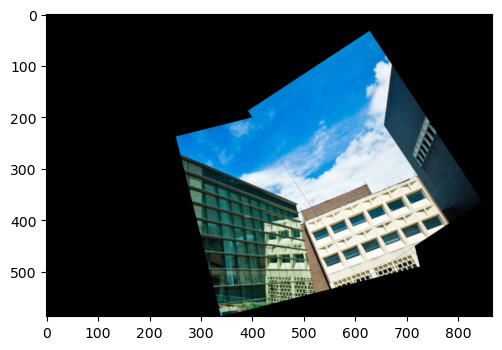

In [13]:
ix23, _ = warp(i12, H23)
show(ix23, dpi=100, disable_axis=False)

(325, 202)


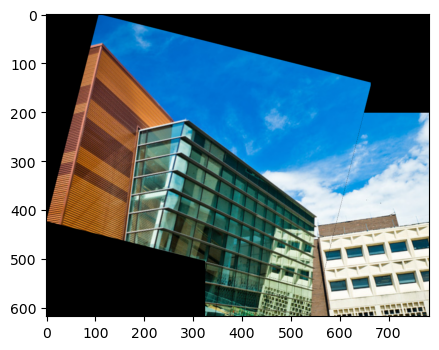

In [14]:
H32 = get_H(imgs1[3], imgs1[2])
i32, p32 = merge(imgs1[3], imgs1[2], H32)
print(p32)
show(i32, dpi=100, disable_axis=False)

In [15]:
def stitch(img1, img2):
    H = get_H(img1, img2)
    img, _ = merge(img1, img2, H)
    return img

In [16]:
def pano(descriptors, imgs, thresh=200):
    n = len(imgs)
    jdx = helper.shape[0]
    root = np.where(helper == 'root')[0]
    to_be_sitiched = np.where(helper[root+1:] == 1)[0]
    
    if to_be_sitiched.shape[0] == 0 or root.shape[0] == 0:
        return imgs[root]
    
    best_n = float('-inf')
    best_nxt = None
    
    for nxt in to_be_sitiched:
        _, n_matches = match_desc(
            descriptors[root],
            descriptors[nxt],
            0.85,
        )
        if n_matches > best_n and n_matches > thresh:
            best_n = n_matches
            best_nxt = nxt
        
    helper[root] = 0
    nxt_roots = np.where(helper == 1)[0]
    if nxt_roots.shape[0] > 0:
        helper[nxt_roots[0]] = 'root'
    
    if next_nxt is not None:
        helper = np.append(helper, 1)
        imgs[jdx] = stitch(imgs[best_nxt], imgs[root])
        _, descriptors[jdx] = extract_features(imgs[jdx])
    

In [18]:
def pano(imgs, descriptors, extractor, thresh=200):
    nxt_imgs = []
    nxt_desc = []
    n = len(imgs)
    helper = np.ones(n)
    curr = 0
    flag = True
    
    while np.where(helper == 1)[0].shape[0] > 0:
        curr = np.where(helper == 1)[0][0]
        # print(f'curr: {curr}')
        helper[curr] = 0
        best_n = float('-inf')
        best_nxt = None
        
        for nxt in np.where(helper == 1)[0]:
            _, n_matches = match_desc(
                descriptors[curr],
                descriptors[nxt],
            )
            # print(curr, nxt, n_matches)
            if n_matches > best_n and n_matches > thresh:
                best_n = n_matches
                best_nxt = nxt
                
        # print(f'best_nxt: {best_nxt}')
        if best_nxt is not None:
            helper[best_nxt] = 0
            # print(f'stitching {best_nxt}, {curr}')
            nxt_imgs.append(stitch(imgs[best_nxt], imgs[curr]))
            _, fd = extract_features(nxt_imgs[-1], extractor)
            nxt_desc.append(fd)
        elif flag is False:
            nxt_imgs.append(imgs[curr])
            nxt_desc.append(descriptors[curr])
            
        flag = False
            
    return nxt_imgs, nxt_desc

In [25]:
def stitch_pano(imgs):
    a = list(imgs.values())
    b = [extract_features(img, sift)[1] for img in a]
    while a:
        a, b = pano(a, b, sift)
        if len(a) != 0:
            res = a  
    return res

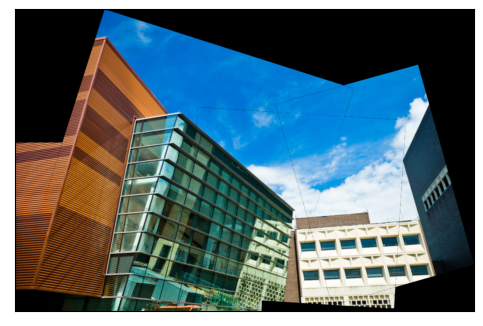

In [22]:
# %%timeit
res = stitch_pano(imgs1)
show(res[0])

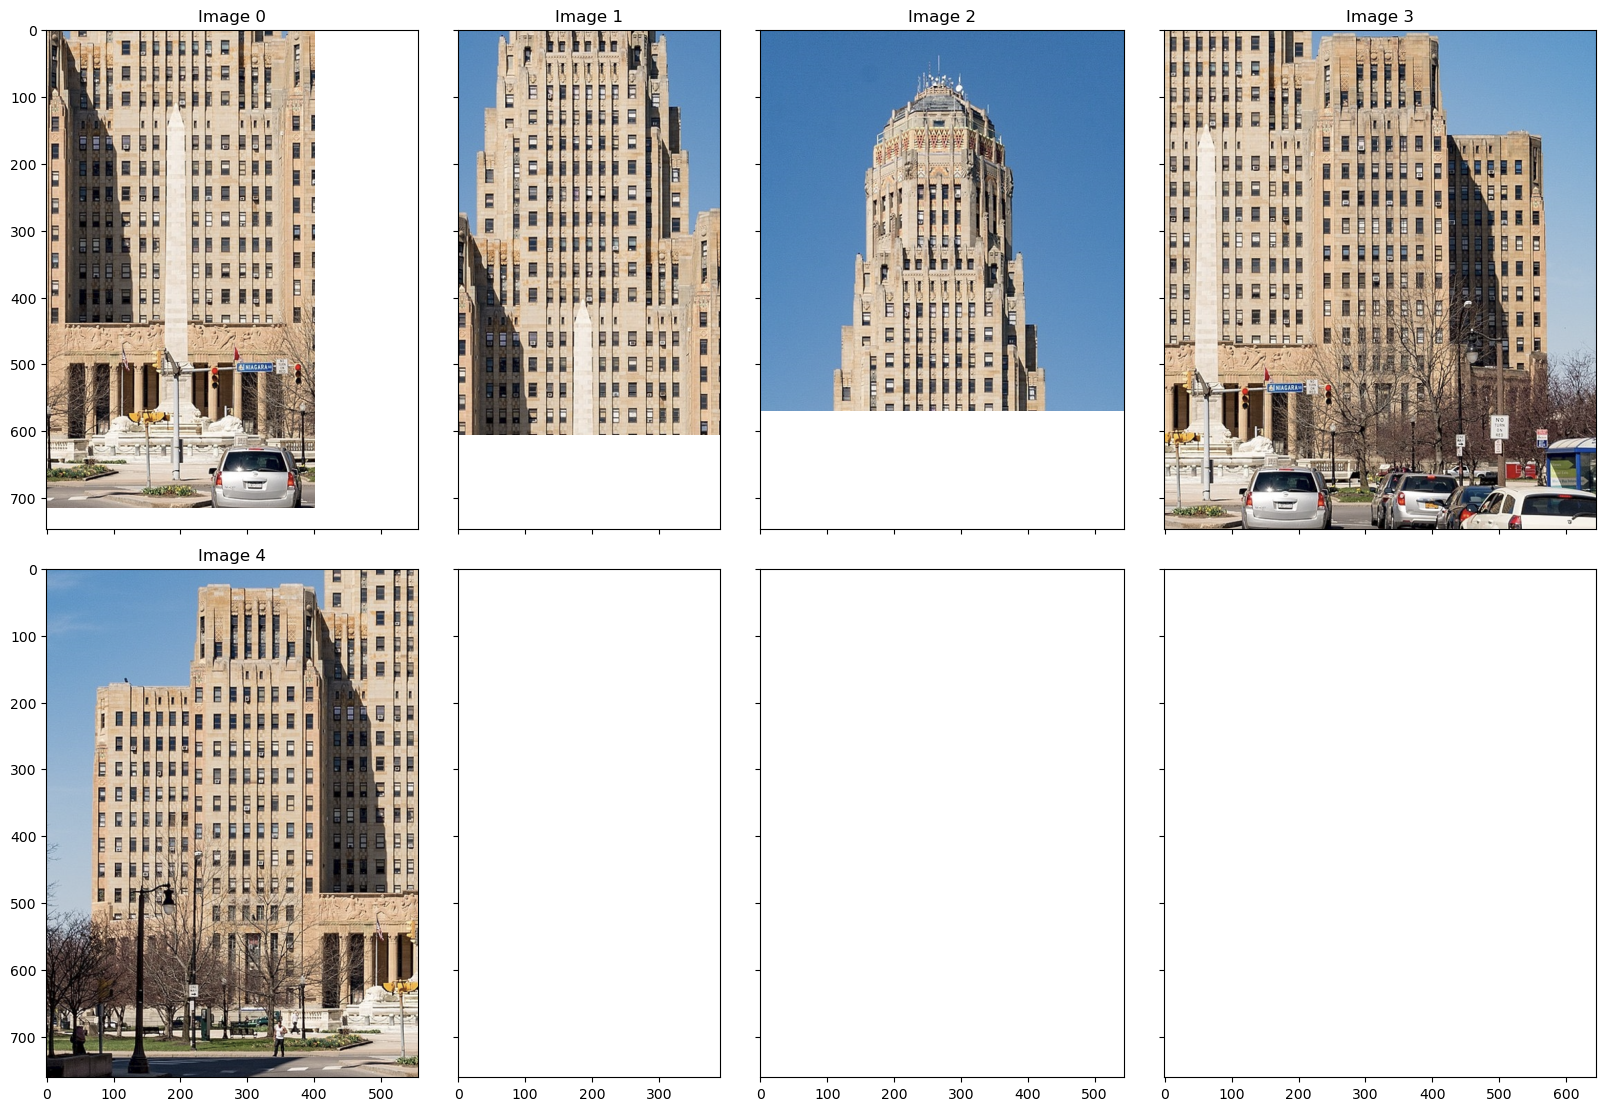

In [23]:
imgs3 = read_batch(BASE_PATH/'3')
show_batch(imgs3.values())

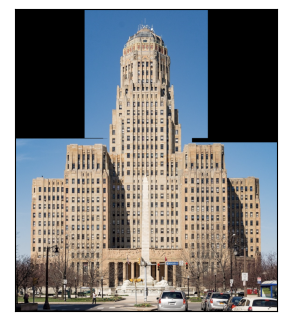

In [26]:
# %%timeit
res = stitch_pano(imgs3)
show(res[0])